In [1]:
import json
import math
import os
import random
import tempfile
import timm
import torch
import augly.image as imaugs
import pandas as pd
import plotly.express as px
from IPython.display import display
from PIL import Image
from torchvision import models, transforms
from torchvision.utils import save_image
from typing import Tuple

In [18]:
# Replace these constants corresponding to the model you want to evaluate!

# The name of your model (loadable using `timm.create_model()`) or a
# function to load your model (e.g. from `torchvision.models`)
model_name = "swin_base_patch4_window12_384"

# The size your model expects images' width & height to be
model_input_size = 384

# The local dir where you have the imagenet validation dataset
dataset_dir = "/checkpoint/zoep/imagenet_analysis/imagenet_val"

# The local path where you have the imagenet val data table json file
data_table_path = (
    "/checkpoint/zoep/imagenet_analysis/imagenet_val_data_table.json"
)

# The local dir where the imagenet val images will be augmented & stored
aug_dataset_dir = "/checkpoint/zoep/imagenet_analysis/imagenet_val_aug"

# The local dir where the precomputed CSVs of metrics for
# VGG/Resnet/Efficientnet are; if you have changed the seed or num_images
# constants below then set this to None so the metrics are all re-computed;
# otherwise the metrics will be loaded from the CSVs to avoid wasting
# computation
precomputed_model_metrics_dir = "/checkpoint/zoep/imagenet_analysis/"

In [4]:
# Only change these constants if you have a reason to

# Keeps the images sampled deterministic
seed = 1245

# The number of images to evaluate on
num_images = 250

# The number of images to run through each model at once; larger batch
# size can cause CUDA to run out of memory depending how much memory
# your GPUs have
batch_size = 20

In [5]:
# Send model + inputs to different devices
devices = [
    torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
]

In [20]:
# Processing transformations which will be applied to all images
base_transforms = [
    lambda path: Image.open(path),
    lambda image: image.convert(mode="RGB"),
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
]

# For the model input above, the image dimensions might be different
custom_model_transforms = [
    lambda path: Image.open(path),
    lambda image: image.convert(mode="RGB"),
    transforms.Resize(model_input_size),
    transforms.CenterCrop(model_input_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
]

# The augmentations we want to test robustness to
augmentations = {
    "blur": imaugs.Blur(radius=3),
    "random_noise": imaugs.RandomNoise(mean=0.1, var=0.2),
    "sharpen": imaugs.Sharpen(factor=10),
    "encoding_quality": imaugs.EncodingQuality(quality=15),
    "change_aspect_ratio": imaugs.ChangeAspectRatio(ratio=3.0),
    "opacity": imaugs.Opacity(level=0.5),
    "pixelization": imaugs.Pixelization(ratio=0.3),
    "scale": imaugs.Scale(factor=0.5),
    "color_jitter": imaugs.ColorJitter(
        brightness_factor=1.6,
        contrast_factor=1.6,
        saturation_factor=1.6,
    ),
    "hflip": imaugs.HFlip(),
    "perspective_transform": imaugs.PerspectiveTransform(),
    "rotate": imaugs.Rotate(degrees=50),
    "vflip": imaugs.VFlip(),
    "overlay_emoji": imaugs.OverlayEmoji(y_pos=0.3, emoji_size=0.8),
    "overlay_text": imaugs.OverlayText(font_size=0.5, x_pos=0.2, y_pos=0.1),
    "overlay_stripes": imaugs.OverlayStripes(
        line_angle=-30,
        line_density=0.9,
        line_width=0.4,
        line_type="dashed",
    ),
    "meme_format": imaugs.MemeFormat(),
}

In [16]:
def sample_images():
    with open(data_table_path) as data_table_file:
        data_table = json.load(data_table_file)
            
    df = pd.DataFrame(data_table["data"])
    df.columns = ["filepath", "class", "class_name"]
    df["filepath"] = df["filepath"].apply(
        lambda path: os.path.basename(os.path.dirname(path))
    )
    df = df.drop_duplicates()
    class_dir_to_id = dict(
        zip(df["filepath"], [str(c) for c in df["class"]]),
    )
        
    sampled_test_images = []
    image_path_to_class_id = {}
    class_id_to_image_paths = {}
    for class_id in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_id)
        if data_table_path is not None:
            class_id = class_dir_to_id[class_id]
        image_paths = os.listdir(class_dir)

        sampled_images = random.sample(image_paths, k=2)
        sampled_test_images.extend(
            [os.path.join(class_dir, image) for image in sampled_images]
        )
        image_path_to_class_id.update(
            {path : class_id for path in sampled_test_images[-2:]}
        )
        class_id_to_image_paths[int(class_id)] = sampled_test_images[-2:]
        
    sampled_test_images = random.sample(sampled_test_images, k=num_images)
    print(f"Sampled {num_images} images to evaluate on")
    return (
        sampled_test_images,
        image_path_to_class_id,
        class_id_to_image_paths,
    )


def augment_images(images, dataset, num_images=num_images):
    num_images = num_images or len(images)
    num_augs = len(augmentations.keys())
    print(f"Augmenting {num_images} images using {num_augs} augmentations")
    
    if not os.path.exists(aug_dataset_dir):
        os.mkdir(aug_dataset_dir)

    aug_images = {}
    for i, image in enumerate(images[:num_images]):
        if (i + 1) % 50 == 0:
            print(f"Augmented {i + 1}/{len(images)} images")
            
        aug_images_dict = {}
        for aug_name, aug in augmentations.items():
            aug_fp = os.path.join(
                aug_dataset_dir,
                f"{image.split('/')[-1].split('.')[0]}_{aug_name}.png",
            )
            aug_images_dict[aug_name] = aug_fp
            if os.path.exists(aug_fp):
                continue
                
            eval_transform = transforms.Compose(
                base_transforms[:1] + [aug] + base_transforms[1:]
            )
            save_image(eval_transform(image), aug_fp)
        aug_images[image] = aug_images_dict

    return aug_images


def get_model(name):
    if name == "resnet":
        model = models.resnet152(pretrained=True)
    elif name == "vgg":
        model = models.vgg16(pretrained=True)
    else:
        model = (
            timm.create_model(name, pretrained=True)
            if isinstance(name, str)
            else name()
        )

    model.eval()
    model = model.half()
    model.to(devices[1])
    return model


def evaluate_one_batch(
    sampled_images_batch,
    aug_sampled_images,
    aug_function,
    image_path_to_class_id,
    model,
    custom_model=False,
):
    to_tensor = transforms.Compose(
        custom_model_transforms if custom_model else base_transforms
    )
    aug_sampled_tensors = [to_tensor(img) for img in aug_sampled_images]
    aug_sampled_tensors = torch.stack(aug_sampled_tensors, dim=0)
    aug_sampled_tensors = aug_sampled_tensors.half().to(devices[1])

    with torch.no_grad():
        model_results = model(aug_sampled_tensors)

    aug_sampled_tensors.to("cpu")
    probabilities = torch.nn.functional.softmax(model_results, dim=1)
    top5_prob, top5_catid = torch.topk(probabilities, 5)

    results = []
    for i in range(len(top5_prob)):
        class_synset_id = os.path.basename(
            os.path.dirname(sampled_images_batch[i]),
        )
        class_id = int(image_path_to_class_id[sampled_images_batch[i]])
        metadata = []
        aug_function(Image.open(sampled_images_batch[i]), metadata=metadata)

        results.append(
            {
                "ground_truth_id": class_id,
                "filepath": sampled_images_batch[i],
                "is_top1_pred": class_id == top5_catid[i][0].item(),
                "is_top5_pred": class_id in top5_catid[i],
                "intensity": metadata[-1]["intensity"],
            }
        )
    
    return results


def evaluate_model_on_augs(
    aug_name,
    aug_function,
    sampled_test_images,
    aug_sampled_images,
    image_path_to_class_id,
    model,
    batch,
    custom_model=False,
    max_images_to_process=num_images,
) -> pd.DataFrame:
    num_batches = math.ceil(len(sampled_test_images) / batch)
    num_batches = (
        num_batches
        if max_images_to_process is None
        else min(num_batches, math.ceil(max_images_to_process / batch))
    )
    
    results = []
    for i in range(num_batches):
        sampled_test_img = sampled_test_images[i * batch : (i + 1) * batch]
        aug_img = sampled_test_img if aug_name is None else [
            aug_sampled_images[img][aug_name] for img in sampled_test_img
        ]
        results.extend(
            evaluate_one_batch(
                sampled_test_img,
                aug_img,
                aug_function,
                image_path_to_class_id,
                model,
                custom_model,
            ),
        )

    return pd.DataFrame(results)


def compute_metrics(base: pd.DataFrame, aug: pd.DataFrame):
    metrics = []
    intensity = f"{aug['intensity'][0]:.2f}"
    for n in {1, 5}:
        base_n = base[f"is_top{n}_pred"]
        aug_n = aug[f"is_top{n}_pred"]

        xor_results = aug_n ^ base_n
        diffs = xor_results[xor_results == True]

        base_topn_accuracy = len(base_n[base_n == True]) / len(base_n)
        aug_topn_accuracy = len(aug_n[aug_n == True]) / len(aug_n)
        metrics.append(aug_topn_accuracy)
        metrics = [aug_topn_accuracy - base_topn_accuracy] + metrics
    
    metrics.append(intensity)
    return metrics


def return_top5_results(img: Image.Image, model) -> Tuple:
    transform = transforms.Compose(base_transforms[1:])
    tensor = transform(img).half().unsqueeze(0).to(devices[1])

    with torch.no_grad():
        model_results = model(tensor)

    probabilities = torch.nn.functional.softmax(model_results, dim=1)
    return torch.topk(probabilities, 5)


def evaluate_model(model_name, custom_model=False):
    # If the precomputed metrics CSVs are available, load from there
    # instead of recomputing
    if precomputed_model_metrics_dir is not None:
        model_name_str = (
            model_name
            if isinstance(model_name, str)
            else getattr(model_name, "__name__", "unnamed_model")
        )
        metrics_csv_path = os.path.join(
            precomputed_model_metrics_dir,
            f"{model_name_str}_robustness_metrics.csv",
        )
        if os.path.exists(metrics_csv_path):
            return pd.read_csv(metrics_csv_path)

    test_set_dir = dataset_dir
    num_sampled_images = len(sampled_test_images)

    random.seed(seed)
    torch.cuda.empty_cache()
    
    model = get_model(model_name)
    
    baseline_df = evaluate_model_on_augs(
        None,
        imaugs.apply_lambda,
        sampled_test_images,
        aug_images,
        image_path_to_class_id,
        model,
        batch=batch_size,
        custom_model=custom_model,
    )

    num_augs = len(augmentations.keys())
    metrics = []
    for i, (aug_name, aug) in enumerate(augmentations.items()):
        aug_df = evaluate_model_on_augs(
            aug_name,
            aug,
            sampled_test_images,
            aug_images,
            image_path_to_class_id,
            model,
            batch=batch_size,
            custom_model=custom_model,
        )
        print(f"Evaluated model on {i + 1}/{num_augs} augmentations")
        metrics.append(
            tuple([aug_name] + compute_metrics(baseline_df, aug_df)),
        )
    
    metrics.sort(key = lambda tup: tup[1])
    metrics = [
        tuple(["NONE"] + compute_metrics(baseline_df, baseline_df))
    ] + metrics

    metrics_df = pd.DataFrame(
        metrics,
        columns=[
            "Augmentation",
            "Top1 acc change",
            "Top5 acc change",
            "Top1 acc",
            "Top5 acc",
            "Intensity",
        ],
    )
    if precomputed_model_metrics_dir is not None:
        metrics_df.to_csv(metrics_csv_path)
        
    return metrics_df


def plot_metrics(dfs, models, filepath):
    num_augs = len(dfs[0]["Augmentation"])
    df_data = []
    for df, model in zip(dfs, models):
        df_data.extend(
            [
                tup
                for tup in sorted(
                    zip(
                        df["Augmentation"],
                        df["Top5 acc change"],
                        [model] * num_augs,
                    ),
                    key = lambda tup: tup[1],
                )
                if tup[0] != "NONE"
            ],
        )
        
    df = pd.DataFrame(
        df_data,
        columns=["Augmentation", "Top5 accuracy change", "Model"],
    )
    fig = px.bar(
        df,
        x="Augmentation",
        y="Top5 accuracy change",
        color="Model",
        barmode="group",
        height=500,
    )
    fig.write_image(filepath)
    return Image.open(filepath)

# Sample images to evaluate

In [8]:
random.seed(seed)
(
    sampled_test_images,
    image_path_to_class_id,
    class_id_to_image_paths,
) = sample_images()

Sampled 250 images to evaluate on


# Augment images

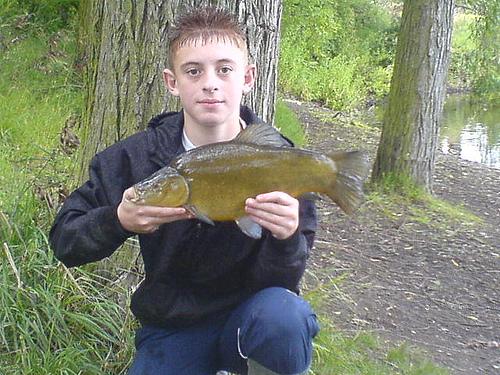

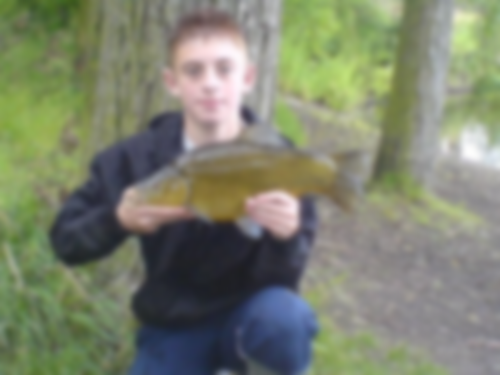

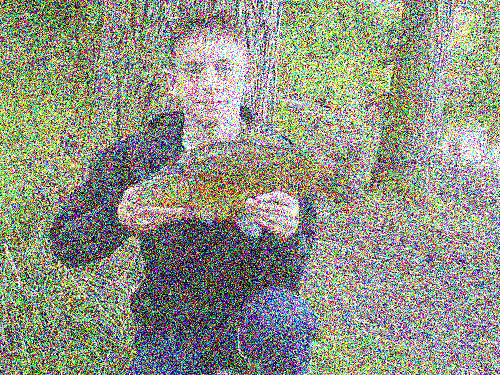

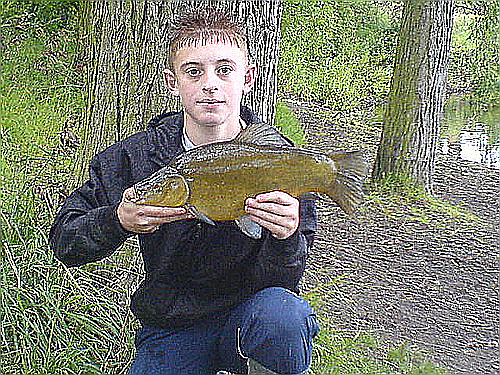

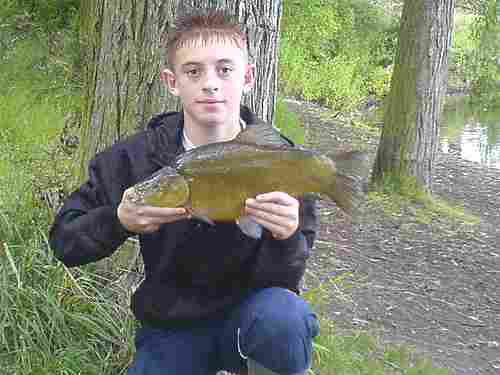

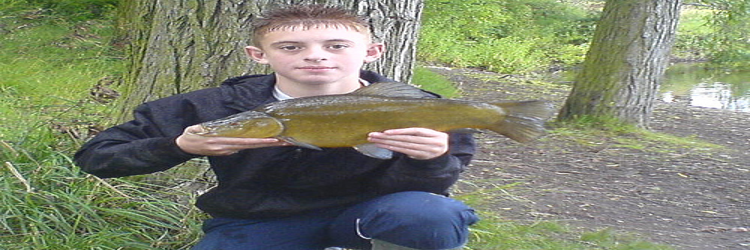

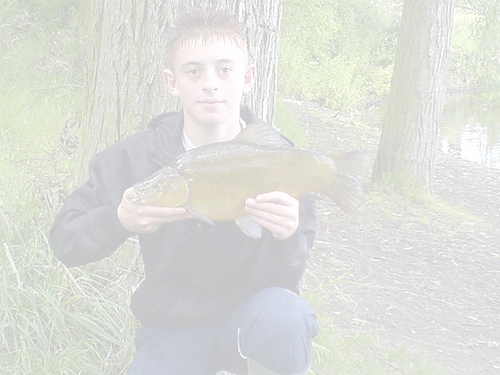

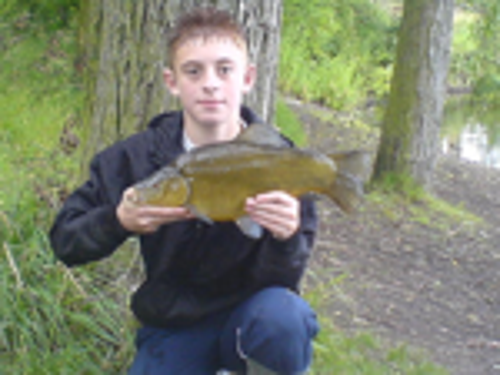

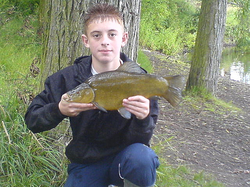

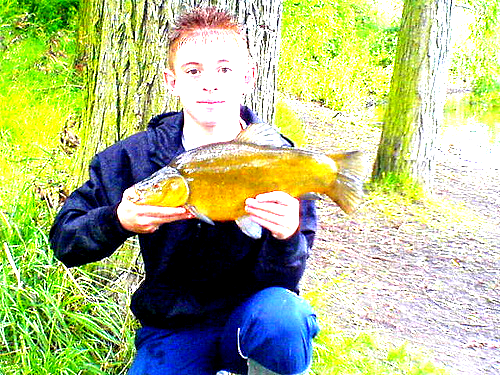

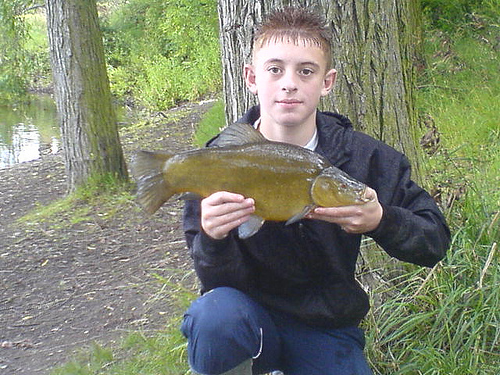

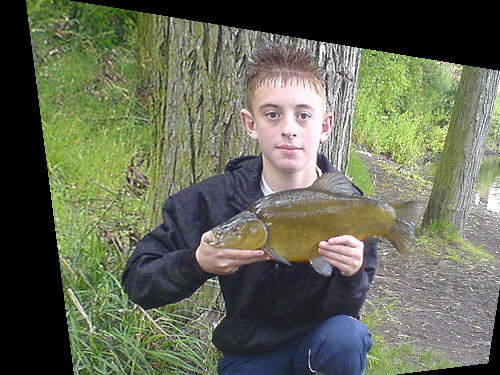

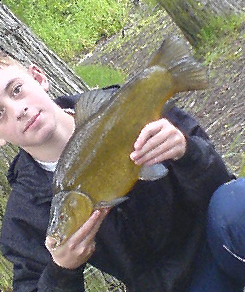

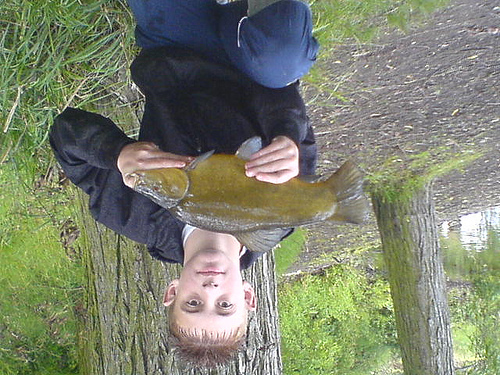

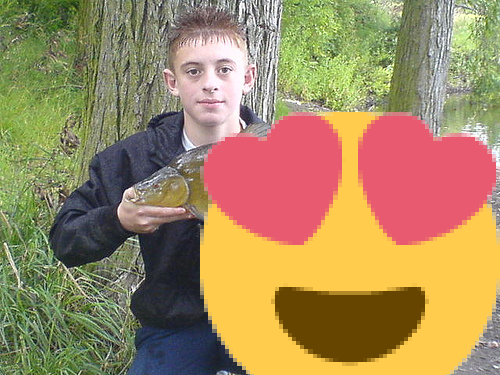

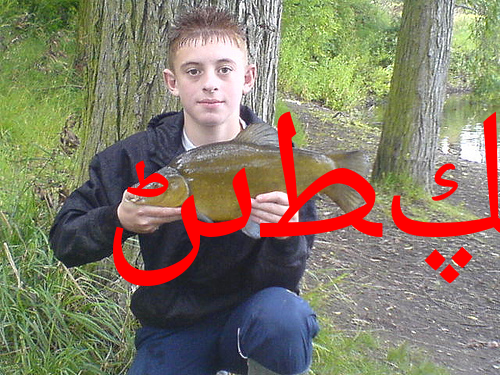

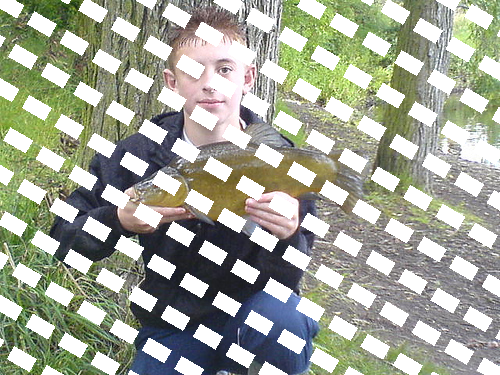

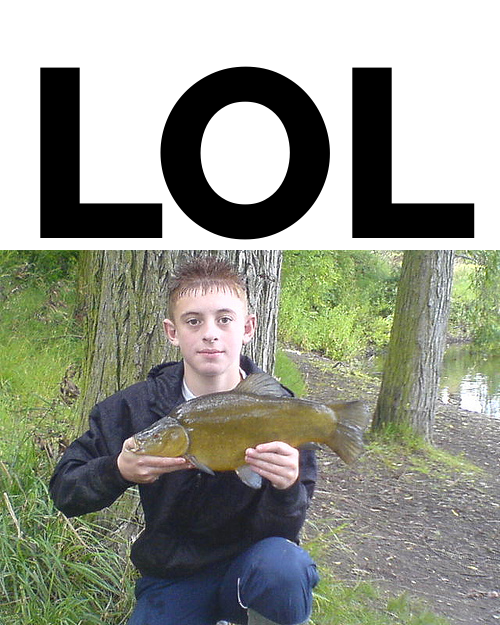

In [9]:
img = Image.open(class_id_to_image_paths[0][0])
display(img)
for aug_name, aug in augmentations.items():
    display(aug(img))

In [10]:
# Augment all of the sampled images, write out to aug_dataset_dir
# {dataset : {image_path : {aug_name: aug_image}}}
aug_images = augment_images(
    sampled_test_images, aug_dataset_dir, num_images
)

Augmenting 250 images using 17 augmentations
Augmented 50/250 images
Augmented 100/250 images
Augmented 150/250 images
Augmented 200/250 images
Augmented 250/250 images


# Compute changes in top1 & top5 accuracy per augmentation

## VGG

In [11]:
# started around 18:03
vgg_df = evaluate_model("vgg")
vgg_df

Unnamed: 0           Augmentation  Top1 acc change  Top5 acc change  \
0            0                   NONE            0.000            0.000   
1            1           random_noise           -0.840           -0.632   
2            2                   blur           -0.816           -0.624   
3            3        overlay_stripes           -0.808           -0.612   
4            4                 rotate           -0.784           -0.620   
5            5           pixelization           -0.772           -0.612   
6            6          overlay_emoji           -0.772           -0.608   
7            7    change_aspect_ratio           -0.760           -0.596   
8            8                sharpen           -0.756           -0.604   
9            9       encoding_quality           -0.740           -0.588   
10          10           color_jitter           -0.740           -0.592   
11          11                  scale           -0.684           -0.568   
12          12           overlay_text           -0.672           -0.568   
13          13                  vflip           -0.656           -0.576   
14          14            meme_format           -0.632           -0.532   
15          15  perspective_transform           -0.592           -0.548   
16          16                  hflip           -0.548           -0.512   
17          17                opacity           -0.500           -0.468   

    Top1 acc  Top5 acc  Intensity  
0      0.632     0.840     100.00  
1      0.000     0.000       0.02  
2      0.008     0.024       5.00  
3      0.020     0.032       7.85  
4      0.012     0.056      27.78  
5      0.020     0.068      70.00  
6      0.024     0.068      64.00  
7      0.036     0.080      30.00  
8      0.028     0.084     100.00  
9      0.044     0.100      85.00  
10     0.040     0.100      16.00  
11     0.064     0.156      20.00  
12     0.064     0.168      25.00  
13     0.056     0.184     100.00  
14     0.100     0.208      40.00  
15     0.084     0.248      50.00  
16     0.120     0.292     100.00  
17     0.164     0.340      50.00

## Resnet

In [12]:
resnet_df = evaluate_model("resnet")
resnet_df

Unnamed: 0           Augmentation  Top1 acc change  Top5 acc change  \
0            0                   NONE            0.000            0.000   
1            1           random_noise           -0.864           -0.672   
2            2                   blur           -0.860           -0.668   
3            3        overlay_stripes           -0.832           -0.652   
4            4                 rotate           -0.816           -0.656   
5            5           pixelization           -0.748           -0.628   
6            6                sharpen           -0.744           -0.620   
7            7    change_aspect_ratio           -0.744           -0.636   
8            8       encoding_quality           -0.740           -0.620   
9            9           color_jitter           -0.732           -0.616   
10          10          overlay_emoji           -0.724           -0.584   
11          11                  vflip           -0.640           -0.556   
12          12            meme_format           -0.620           -0.572   
13          13           overlay_text           -0.600           -0.548   
14          14                  scale           -0.588           -0.540   
15          15  perspective_transform           -0.576           -0.516   
16          16                  hflip           -0.448           -0.412   
17          17                opacity           -0.340           -0.364   

    Top1 acc  Top5 acc  Intensity  
0      0.672     0.876     100.00  
1      0.000     0.012       0.02  
2      0.004     0.016       5.00  
3      0.020     0.044       7.85  
4      0.016     0.060      27.78  
5      0.044     0.128      70.00  
6      0.052     0.132     100.00  
7      0.036     0.132      30.00  
8      0.052     0.136      85.00  
9      0.056     0.144      16.00  
10     0.088     0.152      64.00  
11     0.116     0.236     100.00  
12     0.100     0.256      40.00  
13     0.124     0.276      25.00  
14     0.132     0.288      20.00  
15     0.156     0.300      50.00  
16     0.260     0.428     100.00  
17     0.308     0.536      50.00

## Efficientnet

In [13]:
efficient_df = evaluate_model("tf_efficientnet_l2_ns")
efficient_df

Unnamed: 0           Augmentation  Top1 acc change  Top5 acc change  \
0            0                   NONE            0.000            0.000   
1            1                   blur           -0.324           -0.468   
2            2           random_noise           -0.160           -0.248   
3            3          overlay_emoji           -0.088           -0.136   
4            4    change_aspect_ratio           -0.080           -0.148   
5            5                 rotate           -0.076           -0.112   
6            6           pixelization           -0.064           -0.120   
7            7                  vflip           -0.048           -0.096   
8            8        overlay_stripes           -0.040           -0.072   
9            9       encoding_quality           -0.032           -0.068   
10          10                  scale           -0.032           -0.060   
11          11                opacity           -0.024           -0.048   
12          12           overlay_text           -0.024           -0.012   
13          13            meme_format           -0.024           -0.048   
14          14  perspective_transform           -0.020           -0.036   
15          15                  hflip           -0.008           -0.020   
16          16                sharpen           -0.004            0.008   
17          17           color_jitter           -0.004           -0.032   

    Top1 acc  Top5 acc  Intensity  
0      0.904     0.996     100.00  
1      0.436     0.672       5.00  
2      0.656     0.836       0.02  
3      0.768     0.908      64.00  
4      0.756     0.916      30.00  
5      0.792     0.920      27.78  
6      0.784     0.932      70.00  
7      0.808     0.948     100.00  
8      0.832     0.956       7.85  
9      0.836     0.964      85.00  
10     0.844     0.964      20.00  
11     0.856     0.972      50.00  
12     0.892     0.972      25.00  
13     0.856     0.972      40.00  
14     0.868     0.976      50.00  
15     0.884     0.988     100.00  
16     0.912     0.992     100.00  
17     0.872     0.992      16.00

## Your model

In [21]:
model_4_df = evaluate_model(model_name, custom_model=True)
model_4_df

Evaluated model on 1/17 augmentations
Evaluated model on 2/17 augmentations
Evaluated model on 3/17 augmentations
Evaluated model on 4/17 augmentations
Evaluated model on 5/17 augmentations
Evaluated model on 6/17 augmentations
Evaluated model on 7/17 augmentations
Evaluated model on 8/17 augmentations
Evaluated model on 9/17 augmentations
Evaluated model on 10/17 augmentations
Evaluated model on 11/17 augmentations
Evaluated model on 12/17 augmentations
Evaluated model on 13/17 augmentations
Evaluated model on 14/17 augmentations
Evaluated model on 15/17 augmentations
Evaluated model on 16/17 augmentations
Evaluated model on 17/17 augmentations


Augmentation  Top1 acc change  Top5 acc change  Top1 acc  \
0                    NONE            0.000            0.000     0.872   
1                    blur           -0.216           -0.312     0.560   
2         overlay_stripes           -0.216           -0.376     0.496   
3                   vflip           -0.184           -0.240     0.632   
4           overlay_emoji           -0.184           -0.256     0.616   
5            random_noise           -0.168           -0.248     0.624   
6                  rotate           -0.148           -0.192     0.680   
7     change_aspect_ratio           -0.104           -0.200     0.672   
8            pixelization           -0.088           -0.196     0.676   
9             meme_format           -0.084           -0.124     0.748   
10       encoding_quality           -0.072           -0.124     0.748   
11  perspective_transform           -0.072           -0.088     0.784   
12           overlay_text           -0.064           -0.108     0.764   
13                  scale           -0.052           -0.120     0.752   
14                sharpen           -0.040           -0.100     0.772   
15                opacity           -0.036           -0.060     0.812   
16                  hflip           -0.028           -0.052     0.820   
17           color_jitter           -0.024           -0.076     0.796   

    Top5 acc Intensity  
0      0.980    100.00  
1      0.764      3.00  
2      0.764      7.85  
3      0.796    100.00  
4      0.796     64.00  
5      0.812      0.02  
6      0.832     27.78  
7      0.876     30.00  
8      0.892     70.00  
9      0.896     40.00  
10     0.908     85.00  
11     0.908     50.00  
12     0.916     25.00  
13     0.928     20.00  
14     0.940    100.00  
15     0.944     50.00  
16     0.952    100.00  
17     0.956     16.00

# Plot metrics

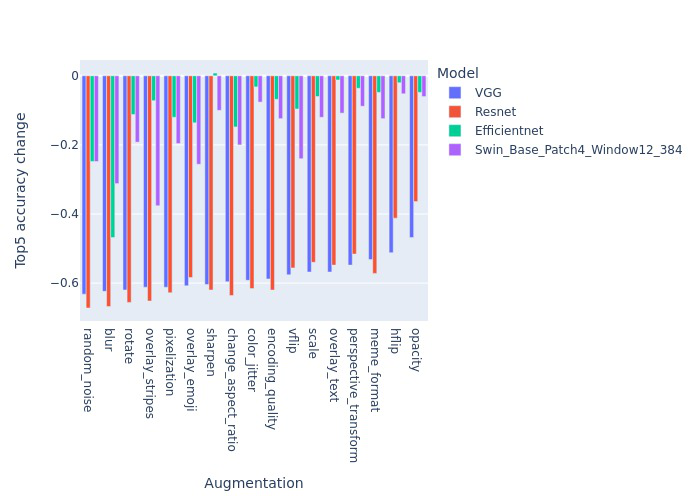

In [22]:
# top5 accuracy ∆ of the model in question caused by different
# augmentations compared to VGG, Resnet, & Efficientnet
with tempfile.TemporaryDirectory() as tempdir:
    model_name_str = (
        model_name
        if isinstance(model_name, str)
        else getattr(model_name, "__name__", "unnamed_model")
    )
    plot = plot_metrics(
        [vgg_df, resnet_df, efficient_df, model_4_df],
        ["VGG", "Resnet", "Efficientnet", model_name_str.title()],
        os.path.join(tempdir, "plot.jpg"),
    )

plot